## Capstone Project - Diamond Prices (Part 2 - Non-Round)

In [2]:
#I was able to get a large dataset of diamond prices from recent years (2017+) through a contact at a diamond aggregator company
#It has more features than the public datasets I looked at on Kaggle
#In addition, it has a robust amount of data for fancy shapes (non-round), while the Kaggle dataset was only for round diamonds
#I will split my model into round and non-round to reflect industry pricing standards (Rapaport guide)
#Example of Rapaport pricing guide: https://www.diamonds.net/Prices/RapaportPriceGuide.aspx

In [66]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.datasets import fetch_openml
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor #added this one to try
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
from xgboost import XGBRegressor #added this to try
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import pickle
import xgboost
from xgboost import XGBClassifier
import plotly as py
import plotly.graph_objs as go
import seaborn as sns

In [4]:
df = pd.read_csv('../assets/Diamond Capstone Fancy (Non Round).csv')
df.head()

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements
0,Cushion,3.20,Excellent,G,VS1,53504.69,GIA,17459430,65.1,58.0,Very Good ...,Good ...,None,0.0,0.0,0.0,0.0,9.14x8.05x5.24
1,Radiant,2.01,Excellent,G,VS2,17643.65,GIA,13444744,68.9,70.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,8.33x6.18x4.26
2,Radiant,3.22,Excellent,E,VS2,50939.81,GIA,15310974,70.1,72.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,8.31x7.96x5.58
3,Cushion,3.08,Very Good,G,VS2,36052.16,GIA,17262201,68.3,66.0,Very Good ...,Good ...,Faint,0.0,0.0,0.0,0.0,9.21x7.83x5.35
4,Asscher,3.01,Very Good,G,VS1,41195.25,GIA,17459424,71.1,67.0,Excellent ...,Good ...,None,0.0,0.0,0.0,0.0,7.81x7.69x5.47


## Exploratory Data Analysis

In [5]:
df.shape
#>50K records, but will need to check if there are a lot of outliers like with the round dataset

(56312, 18)

In [6]:
#check for missing data
df.isnull().sum()
#a lot of them are missing color (~8%) so I will probably impute them somehow instead of dropping
#I will drop the records that are missing polish, symmetry, and fluorescence since they are not big predictors for price typically

shape                 0
carat                 0
cut                   0
color              4555
clarity               0
price                 0
certificateLab        0
certificateID         0
depth_pct             0
table_width_pct       0
polish               66
symmetry            458
fluorescence        292
crownAngle            0
crownHeight           0
pavilionAngle         0
pavilionDepth         0
measurements          0
dtype: int64

In [7]:
#drop the missing data
df.dropna(subset=['fluorescence'], inplace=True)
df.dropna(subset=['symmetry'], inplace=True)
df.dropna(subset=['polish'], inplace=True)

In [8]:
df.isnull().sum()

shape                 0
carat                 0
cut                   0
color              4229
clarity               0
price                 0
certificateLab        0
certificateID         0
depth_pct             0
table_width_pct       0
polish                0
symmetry              0
fluorescence          0
crownAngle            0
crownHeight           0
pavilionAngle         0
pavilionDepth         0
measurements          0
dtype: int64

In [9]:
df.shape
#still have 99% of the data

(55578, 18)

In [10]:
#look at the color data
df['color'].value_counts(dropna = False)
#hard to impute bc there is not one color that stands out as most frequent and color is an important feature for price prediction

E      8572
F      8467
G      8330
D      7464
H      6613
I      5508
NaN    4229
J      3664
K      1757
L       635
M       324
YZ        7
WX        4
N         2
Y         1
UV        1
Name: color, dtype: int64

In [11]:
df[df['color'].isna()].tail(100)
#I used stonealgo's diamond search to look up some of these certificate IDs and it looks like the problem is that these are stones not in the standard color range
#example link: https://www.stonealgo.com/diamond-details/gia-number-1152309323
#examples of non-standard colors: fancy yellow, faint pink
#not enough data for me to work on these types of diamonds so I will have to drop them

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements
52847,Cushion,1.02,Good,NaN,SI2,8160.00,GIA,1258134255,73.8,53.0,Excellent ...,Good ...,Strong,0.0,0.0,0.0,0.0,5.85x5.02x3.71
52848,Cushion,1.17,Very Good,NaN,VS1,4206.74,GIA,6252134379,70.3,55.0,Excellent ...,Good ...,Faint,0.0,0.0,0.0,0.0,5.65x5.61x3.95
52849,Cushion,1.18,Very Good,NaN,VS1,3447.19,GIA,6255132037,69.6,55.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,6.15x5.40x3.76
52850,Cushion,1.19,Very Good,NaN,VVS2,4412.36,GIA,6251132043,69.4,54.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,6.10x5.51x3.83
52851,Cushion,1.30,Very Good,NaN,VS2,4674.16,GIA,3255132054,69.6,56.0,Excellent ...,Very Good ...,None,0.0,0.0,0.0,0.0,6.06x5.71x3.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56210,Emerald,1.01,Fair,NaN,VS1,4141.91,GIA,1152309323,52.7,59.0,Very Good ...,Very Good ...,Medium,0.0,0.0,0.0,0.0,7.37x5.02x2.65
56211,Cushion,2.61,Excellent,NaN,VS1,11255.71,GIA,6245360940,68.5,68.0,Excellent ...,Very Good ...,None,0.0,0.0,0.0,0.0,7.50x7.13x4.88
56232,Cushion,0.73,Excellent,NaN,VS1,1819.72,GIA,1162317476,66.1,60.0,Good ...,Good ...,None,0.0,0.0,0.0,0.0,5.15x4.93x3.26
56244,Cushion,1.11,Very Good,NaN,VS1,2571.82,GIA,1182805769,69.3,52.0,Very Good,Good,Faint,0.0,0.0,0.0,0.0,5.63x5.59x3.87


In [12]:
#drop the records that are missing color
print(df['color'].value_counts(dropna = False))
df.dropna(subset=['color'], inplace=True)
print(df['color'].value_counts(dropna=False))

E      8572
F      8467
G      8330
D      7464
H      6613
I      5508
NaN    4229
J      3664
K      1757
L       635
M       324
YZ        7
WX        4
N         2
Y         1
UV        1
Name: color, dtype: int64
E     8572
F     8467
G     8330
D     7464
H     6613
I     5508
J     3664
K     1757
L      635
M      324
YZ       7
WX       4
N        2
Y        1
UV       1
Name: color, dtype: int64


In [13]:
#confirm there is no more missing data
df.isnull().sum()

shape              0
carat              0
cut                0
color              0
clarity            0
price              0
certificateLab     0
certificateID      0
depth_pct          0
table_width_pct    0
polish             0
symmetry           0
fluorescence       0
crownAngle         0
crownHeight        0
pavilionAngle      0
pavilionDepth      0
measurements       0
dtype: int64

In [14]:
df.shape
#down to 51K records vs. original dataset of 56K (91%), but still a good amount of data to model

(51349, 18)

In [15]:
#take a look at the datatypes
df.dtypes

shape               object
carat              float64
cut                 object
color               object
clarity             object
price              float64
certificateLab      object
certificateID       object
depth_pct          float64
table_width_pct    float64
polish              object
symmetry            object
fluorescence        object
crownAngle         float64
crownHeight        float64
pavilionAngle      float64
pavilionDepth      float64
measurements        object
dtype: object

In [16]:
#double check that I don't have round diamonds in this analysis
df['shape'].value_counts()
#not sure what CM is...

Cushion     11289
Princess     8638
Emerald      6981
Pear         6824
Oval         6489
Marquise     3361
Radiant      3177
Heart        2648
Asscher      1881
CM             61
Name: shape, dtype: int64

In [17]:
df[(df['shape'] == 'CM')].head()
#checked the certificateID and they're all cushion cuts - must be mislabeled
#cushion is the most frequent shape anyway if I were to impute

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements
18939,CM,1.53,Excellent,G,VS2,8724.00,GIA,2246993298,67.2,59.0,Excellent ...,Excellent ...,None,0.0,0.0,0.0,0.0,6.71x6.67x4.48
19000,CM,1.81,Very Good,H,SI1,8772.36,GIA,6241868848,69.7,62.0,Excellent ...,Excellent ...,Faint,0.0,0.0,0.0,0.0,7.46x6.78x4.73
19570,CM,1.50,Excellent,G,VS2,8286.67,GIA,6252175522,67.2,63.0,Excellent ...,Excellent ...,None,0.0,0.0,0.0,0.0,6.86x6.63x4.45
19573,CM,2.03,Excellent,J,VS1,9238.46,GIA,2254183715,65.0,62.0,Excellent ...,Excellent ...,None,0.0,0.0,0.0,0.0,7.62x7.26x4.72
19588,CM,2.01,Excellent,H,VS2,13239.62,GIA,1258183721,65.9,63.0,Excellent ...,Excellent ...,None,0.0,0.0,0.0,0.0,7.60x7.27x4.79


In [18]:
df['shape'] = df['shape'].replace(['CM'], 'Cushion')

In [19]:
df['shape'].value_counts()
#looks good now

Cushion     11350
Princess     8638
Emerald      6981
Pear         6824
Oval         6489
Marquise     3361
Radiant      3177
Heart        2648
Asscher      1881
Name: shape, dtype: int64

In [20]:
#I will follow a similar process for data cleaning:
#re-code cut, color, and clarity since they are non-numerical
#re-code certificateLab using one-hot encoding
#For polish and symmetry, group values before re-coding since there are a lot of possible values

## Re-code Non-Numerical Features

In [21]:
df['color'].value_counts()
#same problem as the round dataset - usually color only goes up to M, so I will drop the others; not sure what the others are

E     8572
F     8467
G     8330
D     7464
H     6613
I     5508
J     3664
K     1757
L      635
M      324
YZ       7
WX       4
N        2
Y        1
UV       1
Name: color, dtype: int64

In [22]:
print(df['color'].value_counts())
df = df.drop(df[df["color"]=='YZ'].index)
df = df.drop(df[df["color"]=='WX'].index)
df = df.drop(df[df["color"]=='N'].index)
df = df.drop(df[df["color"]=='Y'].index)
df = df.drop(df[df["color"]=='UV'].index)
print(df['color'].value_counts())

E     8572
F     8467
G     8330
D     7464
H     6613
I     5508
J     3664
K     1757
L      635
M      324
YZ       7
WX       4
N        2
Y        1
UV       1
Name: color, dtype: int64
E    8572
F    8467
G    8330
D    7464
H    6613
I    5508
J    3664
K    1757
L     635
M     324
Name: color, dtype: int64


In [23]:
#re-code the remaining colors to numerical
print(df['color'].value_counts())
df['color'] = df['color'].map({"D":1, "E": 2, "F":3, "G":4, "H":5, "I":6, "J":7, "K":8, "L":9, "M":10})
print(df['color'].value_counts())

E    8572
F    8467
G    8330
D    7464
H    6613
I    5508
J    3664
K    1757
L     635
M     324
Name: color, dtype: int64
2     8572
3     8467
4     8330
1     7464
5     6613
6     5508
7     3664
8     1757
9      635
10     324
Name: color, dtype: int64


In [24]:
df.shape

(51334, 18)

In [25]:
df['clarity'].value_counts(dropna = False)
#looks normal

SI1     11400
VS2     10192
VS1      9409
SI2      7178
VVS2     5486
VVS1     4398
IF       2049
I1       1134
FL         88
Name: clarity, dtype: int64

In [26]:
#re-code clarity to numerical
print(df['clarity'].value_counts())
df['clarity'] = df['clarity'].map({"FL":1, "IF": 2, "VVS1":3, "VVS2":4, "VS1":5, "VS2":6, "SI1":7, "SI2":8, "I1":9})
print(df['clarity'].value_counts())
#based on the gia guide: https://4cs.gia.edu/en-us/diamond-clarity/

SI1     11400
VS2     10192
VS1      9409
SI2      7178
VVS2     5486
VVS1     4398
IF       2049
I1       1134
FL         88
Name: clarity, dtype: int64
7    11400
6    10192
5     9409
8     7178
4     5486
3     4398
2     2049
9     1134
1       88
Name: clarity, dtype: int64


In [27]:
df.shape

(51334, 18)

In [28]:
df['cut'].value_counts()
#looks normal

Excellent    28863
Very Good    14062
Good          7107
Fair          1300
Ideal            2
Name: cut, dtype: int64

In [29]:
print(df['cut'].value_counts())
df['cut'] = df['cut'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5})
print(df['cut'].value_counts())

Excellent    28863
Very Good    14062
Good          7107
Fair          1300
Ideal            2
Name: cut, dtype: int64
2    28863
3    14062
4     7107
5     1300
1        2
Name: cut, dtype: int64


In [30]:
df['certificateLab'].value_counts()
#vast majority are GIA
#the only other one I've seen is IGI
#group the others

GIA    49449
IGI     1516
HRD      265
AGS      101
B2C        3
Name: certificateLab, dtype: int64

In [31]:
print(df['certificateLab'].value_counts())
df['certificateLab'] = df['certificateLab'].map({"GIA":"GIA", "IGI":"IGI", "HRD":"Other", "AGS":"Other", "B2C":"Other"})
print(df['certificateLab'].value_counts())
#probably not the most efficient way to rename these, but wanted to keep the logic consistent with the rest of the re-coding

GIA    49449
IGI     1516
HRD      265
AGS      101
B2C        3
Name: certificateLab, dtype: int64
GIA      49449
IGI       1516
Other      369
Name: certificateLab, dtype: int64


In [32]:
#now I will get dummies to turn these into numericals
ohe=pd.get_dummies(df['certificateLab'])
print(ohe.columns)
ohe.head()

Index(['GIA', 'IGI', 'Other'], dtype='object')


,GIA,IGI,Other
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [33]:
# append these new columns to the original dataset
df=pd.concat([df, ohe], axis=1) #append columns, not rows
df.shape
#3 extra columns now

(51334, 21)

In [34]:
df.head()

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,...,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements,GIA,IGI,Other
0,Cushion,3.20,2,4,5,53504.69,GIA,17459430,65.1,58.0,...,Good ...,None,0.0,0.0,0.0,0.0,9.14x8.05x5.24,1,0,0
1,Radiant,2.01,2,4,6,17643.65,GIA,13444744,68.9,70.0,...,Very Good ...,None,0.0,0.0,0.0,0.0,8.33x6.18x4.26,1,0,0
2,Radiant,3.22,2,2,6,50939.81,GIA,15310974,70.1,72.0,...,Very Good ...,None,0.0,0.0,0.0,0.0,8.31x7.96x5.58,1,0,0
3,Cushion,3.08,3,4,6,36052.16,GIA,17262201,68.3,66.0,...,Good ...,Faint,0.0,0.0,0.0,0.0,9.21x7.83x5.35,1,0,0
4,Asscher,3.01,3,4,5,41195.25,GIA,17459424,71.1,67.0,...,Good ...,None,0.0,0.0,0.0,0.0,7.81x7.69x5.47,1,0,0


In [35]:
#remove the original column that we replaced with one-hot encoding
df=df.drop(['certificateLab'], axis=1).copy()
df.head()

,shape,carat,cut,color,clarity,price,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements,GIA,IGI,Other
0,Cushion,3.20,2,4,5,53504.69,17459430,65.1,58.0,Very Good ...,Good ...,None,0.0,0.0,0.0,0.0,9.14x8.05x5.24,1,0,0
1,Radiant,2.01,2,4,6,17643.65,13444744,68.9,70.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,8.33x6.18x4.26,1,0,0
2,Radiant,3.22,2,2,6,50939.81,15310974,70.1,72.0,Very Good ...,Very Good ...,None,0.0,0.0,0.0,0.0,8.31x7.96x5.58,1,0,0
3,Cushion,3.08,3,4,6,36052.16,17262201,68.3,66.0,Very Good ...,Good ...,Faint,0.0,0.0,0.0,0.0,9.21x7.83x5.35,1,0,0
4,Asscher,3.01,3,4,5,41195.25,17459424,71.1,67.0,Excellent ...,Good ...,None,0.0,0.0,0.0,0.0,7.81x7.69x5.47,1,0,0


In [36]:
df.shape

(51334, 20)

In [37]:
df['polish'].value_counts()
#looks like some formatting issues like the round data set but also some strange values with ranges? drop these

Excellent                                             25595
Very Good                                             18016
Good                                                   6054
Excellent                                              1302
Very Good                                               271
Fair                                                     51
Ideal                                                    32
Good                                                      9
Very Good-Excel                                           3
Good-Very Good                                            1
Name: polish, dtype: int64

In [38]:
#remove leading / lagging spaces
df['polish'] = df['polish'].str.strip()

In [39]:
df['polish'].value_counts()
#now it looks clean except for the non-standard values

Excellent          26897
Very Good          18287
Good                6063
Fair                  51
Ideal                 32
Very Good-Excel        3
Good-Very Good         1
Name: polish, dtype: int64

In [40]:
#drop those
print(df['polish'].value_counts())
df = df.drop(df[df["polish"]=='Very Good-Excel'].index)
df = df.drop(df[df["polish"]=='Good-Very Good'].index)
print(df['polish'].value_counts())

Excellent          26897
Very Good          18287
Good                6063
Fair                  51
Ideal                 32
Very Good-Excel        3
Good-Very Good         1
Name: polish, dtype: int64
Excellent    26897
Very Good    18287
Good          6063
Fair            51
Ideal           32
Name: polish, dtype: int64


In [41]:
#re-code the remaining ones
print(df['polish'].value_counts())
df['polish'] = df['polish'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5})
print(df['polish'].value_counts())

Excellent    26897
Very Good    18287
Good          6063
Fair            51
Ideal           32
Name: polish, dtype: int64
2    26897
3    18287
4     6063
5       51
1       32
Name: polish, dtype: int64


In [42]:
df['symmetry'].value_counts()
#looks like the same issue as above

Very Good                                             27550
Good                                                  13259
Excellent                                              8339
Fair                                                    878
Excellent                                               758
Very Good                                               464
Good                                                     56
Ideal                                                    15
Poor                                                     11
Name: symmetry, dtype: int64

In [43]:
df['symmetry'] = df['symmetry'].str.strip()

In [44]:
df['symmetry'].value_counts()
#now it looks clean

Very Good    28014
Good         13315
Excellent     9097
Fair           878
Ideal           15
Poor            11
Name: symmetry, dtype: int64

In [45]:
print(df['symmetry'].value_counts())
df['symmetry'] = df['symmetry'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5, "Poor":6})
print(df['symmetry'].value_counts())

Very Good    28014
Good         13315
Excellent     9097
Fair           878
Ideal           15
Poor            11
Name: symmetry, dtype: int64
3    28014
4    13315
2     9097
5      878
1       15
6       11
Name: symmetry, dtype: int64


In [46]:
df.shape

(51330, 20)

In [47]:
df.dtypes

shape               object
carat              float64
cut                  int64
color                int64
clarity              int64
price              float64
certificateID       object
depth_pct          float64
table_width_pct    float64
polish               int64
symmetry             int64
fluorescence        object
crownAngle         float64
crownHeight        float64
pavilionAngle      float64
pavilionDepth      float64
measurements        object
GIA                  uint8
IGI                  uint8
Other                uint8
dtype: object

## Look at the Spread of the Data before Modeling this Time

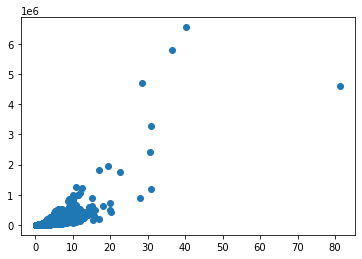

In [48]:
plt.scatter(df['carat'], df['price']);
#there are definitely outliers and some spread issues I will need to account for

In [50]:
df['carat'].describe()

count    51330.000000
mean         1.298742
std          1.197229
min          0.170000
25%          0.710000
50%          1.010000
75%          1.510000
max         81.380000
Name: carat, dtype: float64

In [56]:
df[df['carat']>=2].value_counts()
#8600 are more than 2 carats (~16%) of the data
#try XG boost and see if it works well enough first; otherwise split the data

shape    carat  cut  color  clarity  price      certificateID  depth_pct  table_width_pct  polish  symmetry  fluorescence  crownAngle  crownHeight  pavilionAngle  pavilionDepth  measurements      GIA  IGI  Other
Cushion  4.75   3    7      7        46004.07   1182093745     69.5       62.0             2       2         None          0.00        0.0          0.00           0.0            9.76x9.63x6.70    1    0    0        2
         3.02   2    4      8        21630.34   5181271451     65.9       70.0             3       4         Medium        0.00        0.0          0.00           0.0            8.34x8.33x5.48    1    0    0        2
         4.50   3    7      6        45070.00   2185669581     69.7       62.0             2       2         None          0.00        0.0          0.00           0.0            9.59x9.38x6.54    1    0    0        2
         3.01   3    3      4        50975.38   1265321738     69.7       62.0             2       2         None          0.00        0.

## XG Boost Part (No Carat Cutoff Yet)

In [57]:
#decide which features I want to include
df_xg= df[['price', 'carat', 'cut', 'clarity', 'color', 'Other', 'IGI', 'GIA', 'polish', 'symmetry']].copy()
df_xg.head()

,price,carat,cut,clarity,color,Other,IGI,GIA,polish,symmetry
0,53504.69,3.20,2,5,4,0,0,1,3,4
1,17643.65,2.01,2,6,4,0,0,1,3,3
2,50939.81,3.22,2,6,2,0,0,1,3,3
3,36052.16,3.08,3,6,4,0,0,1,3,4
4,41195.25,3.01,3,5,4,0,0,1,2,4


In [58]:
df_xg.shape

(51330, 10)

In [59]:
df_xg.isnull().sum()

price       0
carat       0
cut         0
clarity     0
color       0
Other       0
IGI         0
GIA         0
polish      0
symmetry    0
dtype: int64

In [61]:
df_xg.dtypes

price       float64
carat       float64
cut           int64
clarity       int64
color         int64
Other         uint8
IGI           uint8
GIA           uint8
polish        int64
symmetry      int64
dtype: object

In [62]:
y = df_xg['price']
print(y.shape)

(51330,)


In [63]:
#remove price from features list
X = df_xg.drop('price', axis=1)
print(X.shape)

(51330, 9)


In [64]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [67]:
#set up the model (arbitrary parameters for now)

xgb_model = XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)

In [68]:
#fit the model
xgb_model.fit(X_train, y_train)
#try the reg:squarederror one later?

[04:44:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, ...)

In [69]:
#predict
y_preds = xgb_model.predict(X_test)

In [70]:
#evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print("RMSE : % f" %(rmse))
#this is pretty high...

RMSE :  17910.156363


In [78]:
#check this vs. using the average
avg_val = y_train.mean()
avg_val

10709.357846325689

In [79]:
#what would the error be if I predicted the average price for all diamonds?
comparison = np.full((len(y_test), ), avg_val)
comparison[:10]

array([10709.35784633, 10709.35784633, 10709.35784633, 10709.35784633,
       10709.35784633, 10709.35784633, 10709.35784633, 10709.35784633,
       10709.35784633, 10709.35784633])

In [80]:
#compare that to my predictions
y_preds[:10]
#very different

array([ 1279.2551,  7550.0356,  1648.2278, 28746.742 ,  4774.1006,
        2801.211 ,  4217.3906,  2344.209 ,  1257.1818,  3631.0828],
      dtype=float32)

In [81]:
#compare these two:
np.sqrt(mean_squared_error(y_test, comparison))
#my RMSE is much better but still high

53009.50277210084

In [77]:
#check r2
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#it's actually not a bad r2 though

0.89

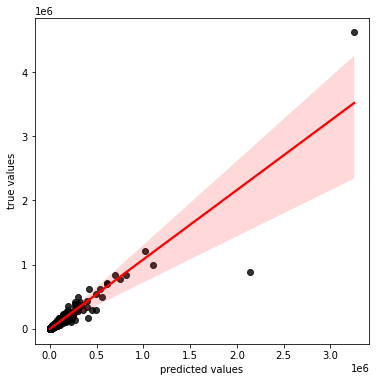

In [71]:
#plot the values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#have to remove those outliers

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


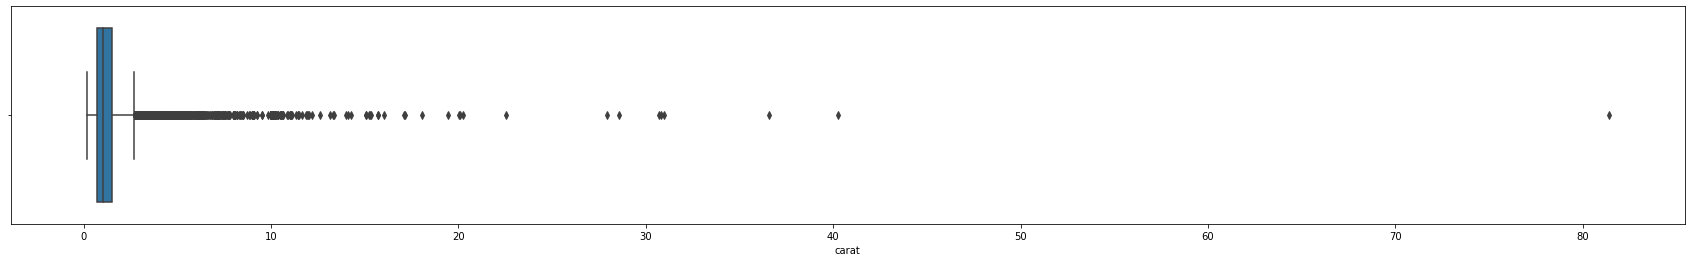

In [76]:
plt.figure(figsize=(30,4))
sns.boxplot(df['carat'])
plt.show()
#a lot of outliers for carat...

In [83]:
df['price'].describe()

count    5.133000e+04
mean     1.069407e+04
std      6.230414e+04
min      1.202800e+02
25%      1.847115e+03
50%      3.488650e+03
75%      7.786885e+03
max      6.554346e+06
Name: price, dtype: float64

## XG Boost Part (Remove Outliers)

In [116]:
df[df['carat']>=2.5].value_counts()
#if I cut it off at 2.5 carats I'd still have >90% of my data

shape    carat  cut  color  clarity  price      certificateID  depth_pct  table_width_pct  polish  symmetry  fluorescence  crownAngle  crownHeight  pavilionAngle  pavilionDepth  measurements      GIA  IGI  Other
Cushion  4.75   3    7      7        46004.07   1182093745     69.5       62.0             2       2         None          0.0         0.0          0.0            0.0            9.76x9.63x6.70    1    0    0        2
         4.50   3    7      6        45070.00   2185669581     69.7       62.0             2       2         None          0.0         0.0          0.0            0.0            9.59x9.38x6.54    1    0    0        2
Emerald  3.01   2    6      5        28418.70   5181705105     65.0       67.0             2       3         None          0.0         0.0          0.0            0.0            9.72x7.1x4.61     1    0    0        2
Cushion  3.02   2    4      8        21630.34   5181271451     65.9       70.0             3       4         Medium        0.0         0.

In [117]:
#create new dataframe with only diamonds 2.5 carats and below for use in any model
df_new = df[(df["carat"]<=2.5)]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


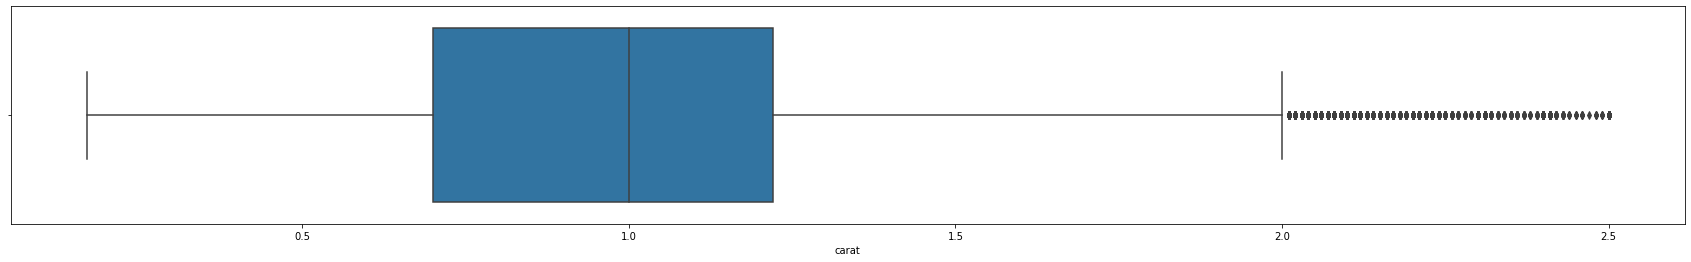

In [118]:
#look at the spread
plt.figure(figsize=(30,4))
sns.boxplot(df_new['carat'])
plt.show()
#definitely still has some outliers, but let me try 2.5 as the cut off first

In [119]:
df_new.shape

(46799, 20)

In [120]:
#decide which features I want to include
df_xg2= df_new[['price', 'carat', 'cut', 'clarity', 'color', 'Other', 'IGI', 'GIA', 'polish', 'symmetry']].copy()
df_xg2.head()

,price,carat,cut,clarity,color,Other,IGI,GIA,polish,symmetry
1,17643.65,2.01,2,6,4,0,0,1,3,3
8,17597.72,2.03,2,7,2,0,0,1,3,3
11,3823.08,0.98,2,6,5,0,0,1,4,4
13,1718.18,0.70,2,8,1,0,0,1,3,4
14,7700.00,1.23,2,5,3,0,0,1,2,4


In [121]:
df_xg2.shape

(46799, 10)

In [122]:
df_xg2.isnull().sum()

price       0
carat       0
cut         0
clarity     0
color       0
Other       0
IGI         0
GIA         0
polish      0
symmetry    0
dtype: int64

In [123]:
df_xg2.dtypes

price       float64
carat       float64
cut           int64
clarity       int64
color         int64
Other         uint8
IGI           uint8
GIA           uint8
polish        int64
symmetry      int64
dtype: object

In [124]:
y = df_xg2['price']
print(y.shape)

(46799,)


In [125]:
#remove price from features list
X = df_xg2.drop('price', axis=1)
print(X.shape)

(46799, 9)


In [126]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [127]:
#set up the model (arbitrary parameters for now)

xgb_model = XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)

In [128]:
#fit the model
xgb_model.fit(X_train, y_train)

[05:03:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, ...)

In [129]:
#predict
y_preds = xgb_model.predict(X_test)

In [130]:
#evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print("RMSE : % f" %(rmse))
#10x lower!

RMSE :  1119.833815


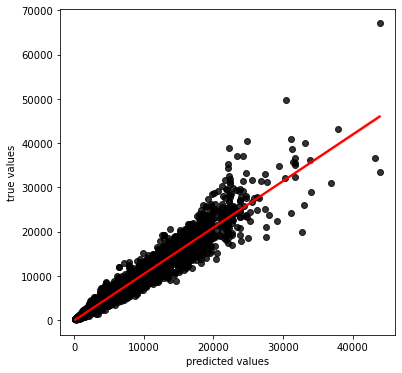

In [131]:
#plot the values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#this one looks so much better

In [132]:
#check r2
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#good now

0.95

## Try to Optimize XG Boost More with Grid Search

In [133]:
#got this from some googling - not sure what all of it means...
xgb_gs = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

In [134]:
xgb_grid = GridSearchCV(xgb_gs,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [135]:
xgb_grid.fit(X_train,
        y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[05:05:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:05:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/learner.cc:627: 
Parameter

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [136]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9540301133752954
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [137]:
#new model with grid search parameters
xgb_model = XGBRegressor(colsample_bytree= 0.7, 
                         learning_rate= 0.03, 
                         max_depth= 5, 
                         min_child_weight= 4,
                         n_estimators= 500,
                         nthread= 4, 
                         objective= 'reg:linear', 
                         silent= 1,
                         subsample= 0.7)

In [138]:
#fit the model
xgb_model.fit(X_train, y_train)

[05:20:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, ...)

In [140]:
#predict
y_preds = xgb_model.predict(X_test)

In [141]:
#evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print("RMSE : % f" %(rmse))
#a little lower

RMSE :  1075.244015


In [142]:
#check r2
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#same r2

0.95

In [143]:
#try with the reg:squarederror instead?
#new model with grid search parameters but using squarederror
xgb_model = XGBRegressor(colsample_bytree= 0.7, 
                         learning_rate= 0.03, 
                         max_depth= 5, 
                         min_child_weight= 4,
                         n_estimators= 500,
                         nthread= 4, 
                         objective= 'reg:squarederror', 
                         silent= 1,
                         subsample= 0.7)

In [144]:
#fit the model
xgb_model.fit(X_train, y_train)

[05:22:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562802298/work/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [145]:
#predict
y_preds = xgb_model.predict(X_test)

In [146]:
#evaluate with RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print("RMSE : % f" %(rmse))
#same thing

RMSE :  1075.244015


In [147]:
#check r2
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#same r2
#also same

0.95

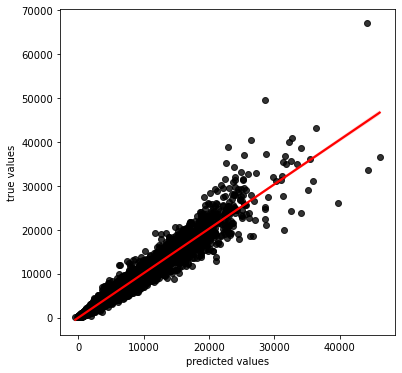

In [148]:
#final plot
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');

In [ ]:
#add CV?

In [235]:
#now that the non-numerical data has been recoded, check correlations to see which features are most important
corrs = df.corr()
corrs

,carat,cut,color,clarity,price,depth_pct,table_width_pct,polish,symmetry,crownAngle,crownHeight,pavilionAngle,pavilionDepth,GIA,IGI,Other
carat,1.000000,-0.050591,0.171670,0.132576,0.637117,-0.010548,0.007491,-0.060851,-0.062518,-0.081628,0.068631,-0.089084,0.068405,-0.056137,0.018278,0.100094
cut,-0.050591,1.000000,0.089870,0.160564,-0.045399,0.372406,0.127114,0.477362,0.680819,-0.031207,0.071119,-0.095261,0.077172,-0.011728,0.030142,-0.041922
color,0.171670,0.089870,1.000000,0.121075,-0.003480,0.050699,0.000287,0.042824,0.062533,-0.044856,-0.011096,-0.102827,-0.011259,-0.150830,0.151462,0.024625
clarity,0.132576,0.160564,0.121075,1.000000,-0.017231,0.051504,0.003100,0.176263,0.145407,-0.066286,0.036141,-0.140621,0.034632,-0.051956,0.037043,0.044599
price,0.637117,-0.045399,-0.003480,-0.017231,1.000000,-0.027171,0.005490,-0.036267,-0.044734,-0.020073,0.027495,-0.021929,0.027763,-0.011505,-0.005593,0.042807
depth_pct,-0.010548,0.372406,0.050699,0.051504,-0.027171,1.000000,-0.114810,0.013411,0.179377,0.054551,-0.030638,0.031811,-0.045749,-0.067454,0.078489,-0.014654
table_width_pct,0.007491,0.127114,0.000287,0.003100,0.005490,-0.114810,1.000000,0.165804,0.141389,-0.038417,0.021449,-0.027021,0.042893,0.077624,-0.076569,-0.015969
polish,-0.060851,0.477362,0.042824,0.176263,-0.036267,0.013411,0.165804,1.000000,0.555279,-0.072541,0.123392,-0.113207,0.132774,0.064203,-0.038421,-0.072665
symmetry,-0.062518,0.680819,0.062533,0.145407,-0.044734,0.179377,0.141389,0.555279,1.000000,-0.029883,0.087139,-0.084706,0.096814,-0.025881,0.057681,-0.071421
crownAngle,-0.081628,-0.031207,-0.044856,-0.066286,-0.020073,0.054551,-0.038417,-0.072541,-0.029883,1.000000,-0.060690,0.741977,-0.065333,-0.022768,0.022330,0.004989


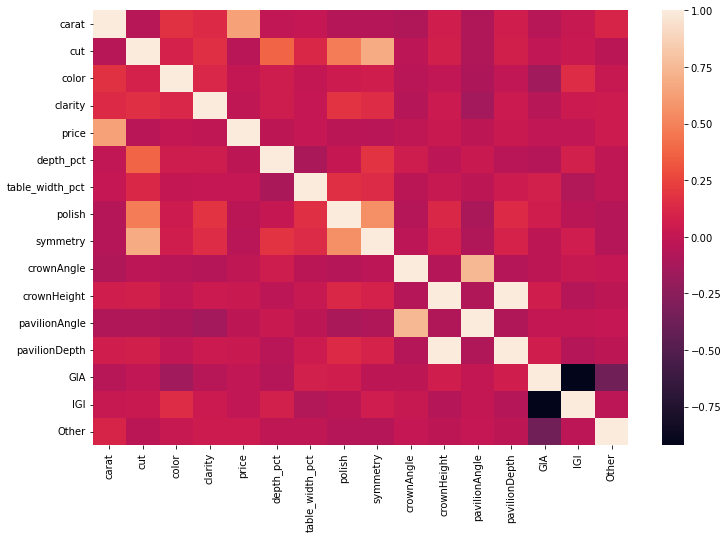

In [236]:
#heatmap to see the correlations more clearly
plt.figure(figsize=(12,8))
sns.heatmap(corrs);

In [237]:
corrs['price'].sort_values()
#similar to my last diamond price analysis; not seeing anything with strong correlation to price besides "carat". 

cut               -0.045399
symmetry          -0.044734
polish            -0.036267
depth_pct         -0.027171
pavilionAngle     -0.021929
crownAngle        -0.020073
clarity           -0.017231
GIA               -0.011505
IGI               -0.005593
color             -0.003480
table_width_pct    0.005490
crownHeight        0.027495
pavilionDepth      0.027763
Other              0.042807
carat              0.637117
price              1.000000
Name: price, dtype: float64

In [264]:
#take a quick look ta the target variable
df.describe()
#the scale of price is weird?

,carat,cut,color,clarity,price,depth_pct,table_width_pct,polish,symmetry,crownAngle,crownHeight,pavilionAngle,pavilionDepth,GIA,IGI,Other
count,110458.000000,110458.000000,110458.000000,110458.000000,1.104580e+05,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000
mean,0.835177,2.432345,3.993636,5.295479,5.948045e+03,62.179623,57.959398,2.224529,2.400297,22.540216,0.734238,27.095983,2.221817,0.917752,0.070597,0.011651
std,0.793164,0.725324,2.296074,1.909995,3.049067e+04,2.252075,2.438332,0.495710,0.652255,19.660037,3.182180,19.616273,9.573749,0.274744,0.256152,0.107312
min,0.140000,1.000000,1.000000,1.000000,1.447800e+02,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,2.000000,4.000000,7.499050e+02,61.200000,57.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.600000,2.000000,4.000000,5.000000,1.660575e+03,62.200000,58.000000,2.000000,2.000000,33.500000,0.000000,40.800000,0.000000,1.000000,0.000000,0.000000
75%,1.010000,3.000000,6.000000,7.000000,4.798540e+03,62.900000,59.000000,2.000000,3.000000,35.500000,0.000000,41.200000,0.000000,1.000000,0.000000,0.000000
max,25.250000,5.000000,10.000000,9.000000,3.777064e+06,79.800000,90.000000,5.000000,6.000000,3605.000000,20.000000,69.800000,48.500000,1.000000,1.000000,1.000000


In [267]:
#make a copy of the data with only the features I will model
df= df[['price', 'carat', 'cut', 'clarity', 'color', 'Other', 'IGI', 'GIA', 'polish', 'symmetry']].copy()
df.head()

,price,carat,cut,clarity,color,Other,IGI,GIA,polish,symmetry
0,96980.26,3.01,3,6,1,0,0,1,3,2
1,7722.58,1.26,2,7,6,0,0,1,2,2
2,239200.00,4.03,3,5,2,0,0,1,2,3
3,27508.00,1.86,2,6,2,0,0,1,2,2
4,84081.29,4.28,3,7,5,0,0,1,2,3


In [268]:
#declare the target variable
y = df['price']
y.shape

(110458,)

In [269]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(110458, 9)

In [289]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [290]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [291]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [292]:
print(mymodel)

LinearRegression(normalize=False)


In [293]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$6K
#doesn't really tell us much since that wouldn't happen in the real world

-6223.282503754364

In [294]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)
#cut, clarity, and color all have negative intercepts because I mapped the "best" to 1 with ascending values after that so that makes sense

Regression Equation:  y = -6223.28 + 25688.87*carat + -42.65*cut + -1551.34*clarity + -1452.4*color + -2764.06*Other + 1531.52*IGI + 1232.54*GIA+ 1460.12*polish+ 159.93*symmetry


In [295]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [296]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,25688.872576
1,cut,-42.645817
2,clarity,-1551.339669
3,color,-1452.400344
4,Other,-2764.059526
5,IGI,1531.521900
6,GIA,1232.537625
7,polish,1460.123291
8,symmetry,159.929342


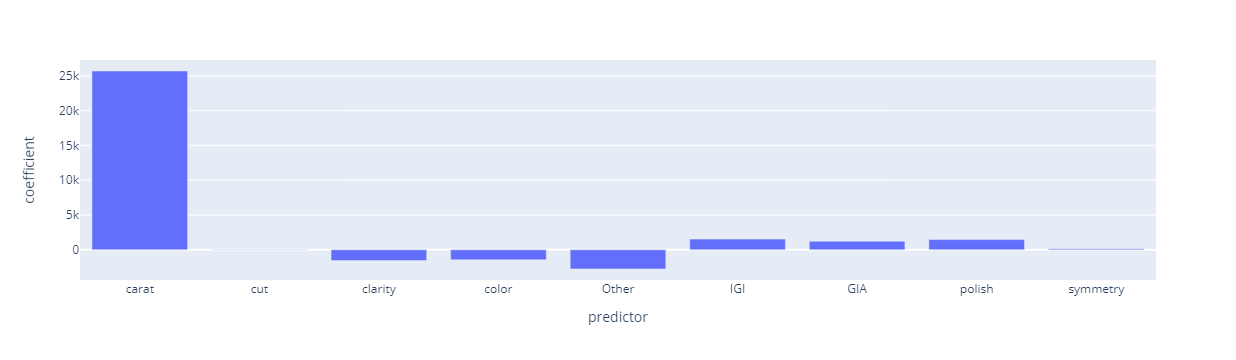

In [297]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()
#surprisingly, cut doesn't seem to have much of an impact
#the magnitude of impact for clarity and color match my understanding based on the Rapaport pricing guide

In [298]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [299]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#looks very wrong...

[-1768.99, -7773.14, 1799.41, -3773.22, 36894.12]
[709.06, 508.25, 1386.01, 872.56, 19053.05]


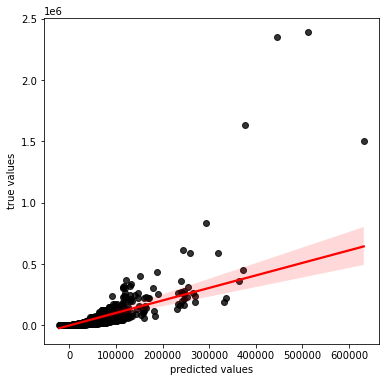

In [300]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#something weird is going on

## Model Evaluation

In [301]:
#root mean sq error
rmse = sqrt(metrics.mean_squared_error(y_test, y_preds))
rmse

21808.183754717873

In [302]:
#is that more or less than if we just used the average as our model?
avg_val = y_train.mean()
avg_val

5964.082332605049

In [303]:
#what would the error be if I predicted the average price for all diamonds?
comparison = np.full((len(y_test), ), avg_val)
comparison[:10]

array([5964.08233261, 5964.08233261, 5964.08233261, 5964.08233261,
       5964.08233261, 5964.08233261, 5964.08233261, 5964.08233261,
       5964.08233261, 5964.08233261])

In [304]:
#compare that to my predictions
y_preds[:10]
#something is very off because the values are negative

array([ -1768.98872225,  -7773.13788229,   1799.40635101,  -3773.22091911,
        36894.12244705,  -2112.93461035, 105839.14026801, -10086.59243056,
          365.35020626,   9010.53486373])

In [305]:
#compare these two:
sqrt(metrics.mean_squared_error(y_test, comparison))

29911.671286357705

In [306]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#very bad...need to fix something

0.47

## Additional EDA / Cleanup

In [308]:
df['price'].describe()
#why is it like this??
#do I need to remove outliers?

count    1.104580e+05
mean     5.948045e+03
std      3.049067e+04
min      1.447800e+02
25%      7.499050e+02
50%      1.660575e+03
75%      4.798540e+03
max      3.777064e+06
Name: price, dtype: float64

In [309]:
df['color'].describe()
#this one looks normal

count    110458.000000
mean          3.993636
std           2.296074
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          10.000000
Name: color, dtype: float64

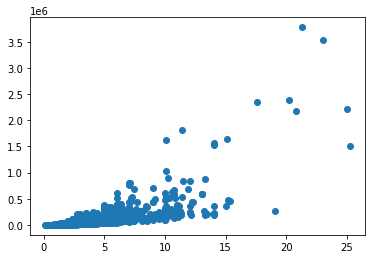

In [312]:
#look at the spread of the data to see if there are outliers
plt.scatter(df['carat'], df['price']);
#there are definitely some outliers probably making it hard to predict well
#not sure how to systematically remove the outliers but I will cut it off at 10 carats for now since most of the data lies below that

In [313]:
df.shape

(110458, 10)

## Remove Outliers and Re-Model

In [316]:
#drop the outliers
df = df[(df["carat"]<10)]

In [317]:
df.shape
#didn't lose much data

(110365, 10)

In [318]:
#try the model again
#declare the target variable
y = df['price']
y.shape

(110365,)

In [319]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(110365, 9)

In [320]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [321]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [322]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [323]:
print(mymodel)

LinearRegression(normalize=False)


In [324]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$2K
#this looks better than before already!

-1891.4552320532084

In [325]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)

Regression Equation:  y = -1891.46 + 17577.64*carat + -329.89*cut + -945.52*clarity + -935.66*color + -1036.88*Other + 536.86*IGI + 500.02*GIA+ 804.19*polish+ 38.74*symmetry


In [326]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [327]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,17577.639179
1,cut,-329.892596
2,clarity,-945.520030
3,color,-935.656494
4,Other,-1036.876090
5,IGI,536.856175
6,GIA,500.019915
7,polish,804.190442
8,symmetry,38.735434


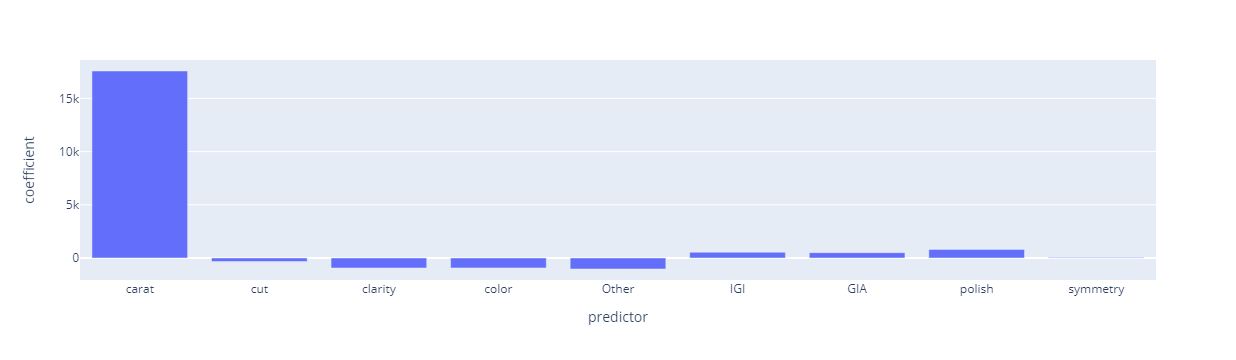

In [328]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()

In [329]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [330]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#still looks wrong...

[2232.65, 233.73, 14331.97, -3010.36, -2050.27]
[1472.33, 2065.8, 6993.81, 838.45, 970.0]


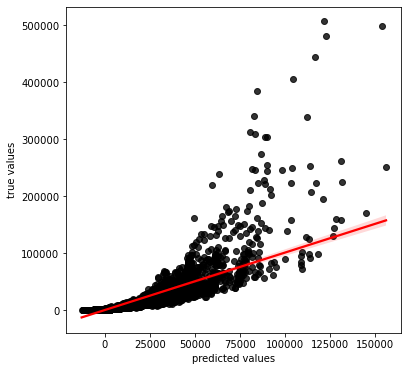

In [331]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#still too much spread

## Model Evaluation v2

In [332]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#better but probably still need to make the cutoff lower due to high spread in the larger carat ranges

0.63

## Remove Outliers and Re-Model v2

In [335]:
#drop the outliers
df = df[(df["carat"]<2)]
#did a quick check for outliers using IQR in excel; seems like most of the data is below 2 carats which aligns with what I expected

In [336]:
df.shape
#still have over 90% of the original data

(102212, 10)

In [337]:
#try the model again
#declare the target variable
y = df['price']
y.shape

(102212,)

In [338]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(102212, 9)

In [339]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [340]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [341]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [342]:
print(mymodel)

LinearRegression(normalize=False)


In [343]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$200
#this looks better than before already!

-206.48568263484003

In [344]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)

Regression Equation:  y = -206.49 + 8797.76*carat + -270.84*cut + -281.78*clarity + -310.54*color + -419.5*Other + 164.88*IGI + 254.62*GIA+ 197.41*polish+ -44.3*symmetry


In [345]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [346]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,8797.757869
1,cut,-270.841058
2,clarity,-281.776828
3,color,-310.538868
4,Other,-419.499582
5,IGI,164.884575
6,GIA,254.615007
7,polish,197.412728
8,symmetry,-44.295248


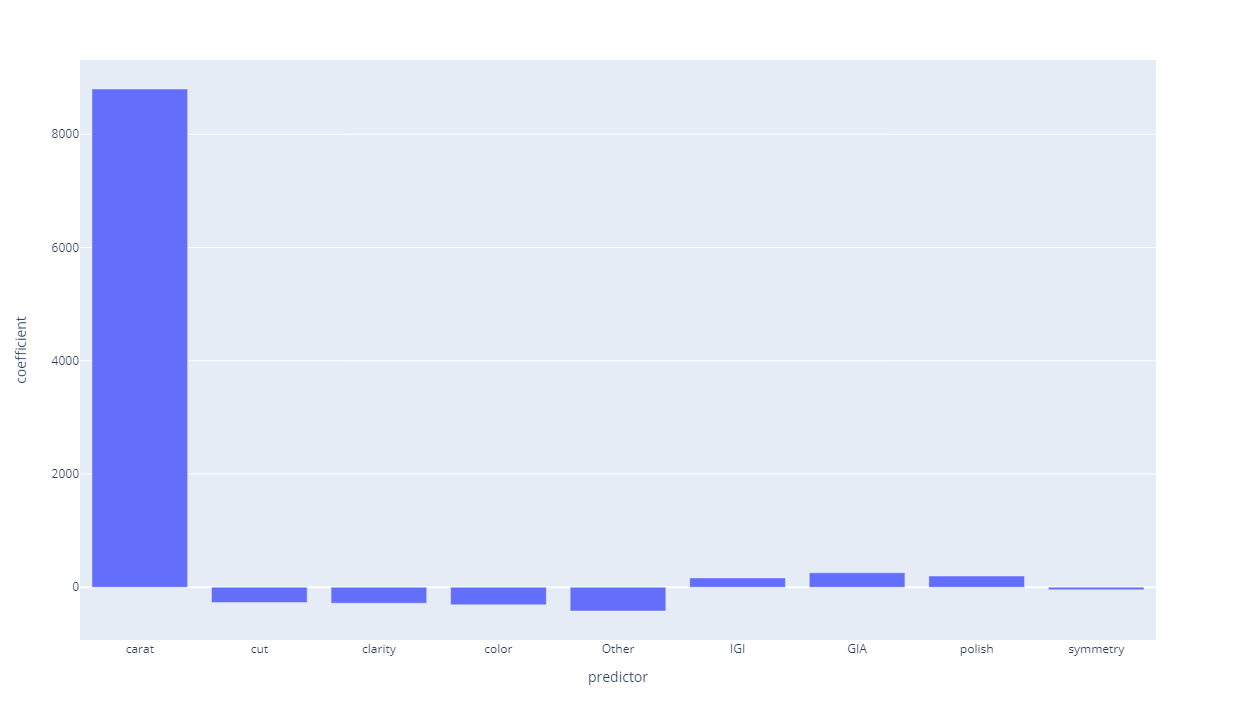

In [347]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()

In [348]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [349]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#much closer!!!

[5085.31, 7015.13, 1910.36, 1786.41, 87.98]
[4525.68, 7091.69, 1102.14, 1152.11, 509.67]


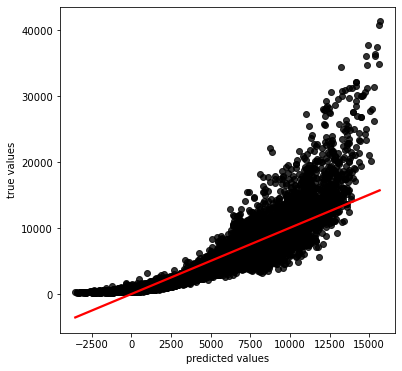

In [350]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#still a lot more spread than I expected

In [351]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#much better than before but still an interesting curve; seems like for the lower carat ranges, the linear relationship / modeling works well, but in the higher carat ranges, prices diverge more and start to look more parabolic. this makes sense because these sizes are probably much rarer so buyers will have to pay an extra premium above the features I have included in the model

0.81

In [ ]:
#other things I want to try:
#is there a parabolic model?
#or I could split the model even further into different carat ranges...
#have to check if there is enough data for that though

In [ ]:
#add the scatter plots by carat range here